<a href="https://colab.research.google.com/github/simonepascucci/progettoLAB-IA/blob/main/finalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installazione prerequisiti per il corretto funzionamento del notebook

In [ ]:
!pip install easyocr
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install --ignore-installed Pillow==9.0.0

#Importazione delle varie librerie python utilizzate

In [1]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import easyocr
import pytesseract
import imutils
reader = easyocr.Reader(['en'])


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [2]:
def display(img, title):
  print(title)
  print()
  cv2_imshow(img)

In [ ]:
from google.colab import drive
drive.mount()

In [3]:
cd ./drive/MyDrive/tensorflow-yolov4-tflite-master

/content/drive/MyDrive/tensorflow-yolov4-tflite-master


#1 - Caricamento di un' immagine casuale da un dataset di 433 foto di auto

Foto prese dal dataset "car plate detection" di Kaggle.

In [4]:
img_number = str(np.random.randint(0, 433))
print(img_number)
command = 'python detect.py --weights ./checkpoints/custom-416 --size 416 --model yolov4 --images ./data/images/Cars'+img_number+'.png --crop'

152


#2 - Object detection:

Modello realizzato con Yolo v4, addestrato su un dataset di google open dataset (Vehicle plate recognition) in grado di riconoscere targhe su foto, video e webcam

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening '/tmp/tmpws26lz4n.PNG'


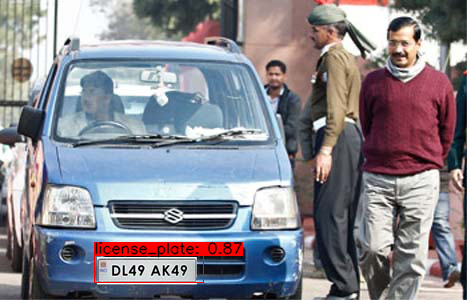

In [5]:
!{command}
res = cv2.imread("/content/drive/MyDrive/tensorflow-yolov4-tflite-master/detections/detection1.png")
cv2_imshow(res)

#3 - License plate extraction:

Il modello precedentemente addestrato salverà una copia di ogni targa riconosciuta all'interno della foto. In caso di video o webcam ogni 30fps verrà effettuata una cattura della schermata e andranno salvate le targhe presenti all'interno di quest' ultima.

0 - Recognized plate with my YOLO v4 custom model:



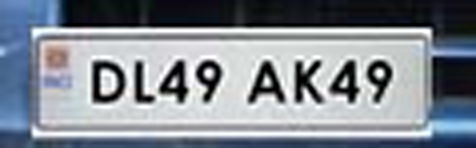

In [19]:
plate_PATH = '/content/drive/MyDrive/tensorflow-yolov4-tflite-master/detections/crop/Cars'+img_number+'/license_plate_1.png'
p = cv2.imread(plate_PATH)
from scipy.ndimage import interpolation
plate = cv2.resize(p, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
h = plate.shape[0]
w = plate.shape[1]
h1 = int(0.05 * h)
w1 = int(0.05 * w)
display(plate, '0 - Recognized plate with my YOLO v4 custom model:')

#--- Inizio Object character recognition --- 

#Preprocessing

- L'esecuzione di questa cella ridurra ogni volta del 5% l'altezza della targa (Per ridurre la possibilità di errore).

Vertically cropped plate: (for plate with extra border)



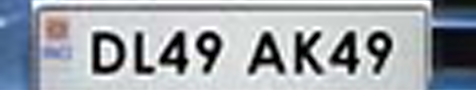

In [24]:
h = plate.shape[0]
w = plate.shape[1]
h1 = int(0.05 * h)
w1 = int(0.05 * w)
plate = plate[h1 : h-h1, 0:w]
display(plate, 'Vertically cropped plate: (for plate with extra border)')

 - L' esecuzione di questa cella ridurra ogni volta del 5% la larghezza della targa (Per ridurre la possibilità di errore).

Horizontally cropped plate: (for plate with extra border)



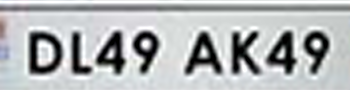

In [27]:
h = plate.shape[0]
w = plate.shape[1]
h1 = int(0.05 * h)
w1 = int(0.05 * w)
plate = plate[0 : h ,w1 : w-w1]
display(plate, 'Horizontally cropped plate: (for plate with extra border)')

#Skew correction:

Eseguire la cella sottostante impostando i gradi (>0 ruota in senso antiorario) per correggere la rotazione.

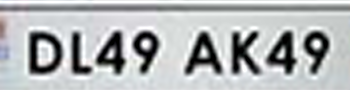

In [28]:
plane = imutils.rotate(plate,0)
display(plane, '')

#Grayscaling and noise reduction:

Trasformazione della targa in scala di grigi e applicazione di un filtro (Gaussiano o bilaterale) per ridurre il più possibile le impurità presenti.

1 - Gaussian blur on grayscale plate: 



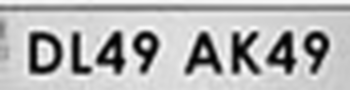

1 - Bilateral filter blur on grayscale plate: 



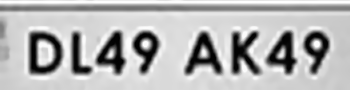

In [30]:
gray = cv2.cvtColor(plane, cv2.COLOR_BGR2GRAY)
#gray = cv2.bitwise_not(gray)
gblur = cv2.GaussianBlur(gray, (5, 5), 0)
bfilter = cv2.bilateralFilter(gray, 11, 10, 10)
display(gblur, '1 - Gaussian blur on grayscale plate: ')
display(bfilter, '1 - Bilateral filter blur on grayscale plate: ')

#Binarization:

Thresholding attraverso il metodo OTSU che andrà a invertire i colori di sfondo e numeri per favorire le prossime fasi.

2 - Binarization with OTSU thresholding method (For white plates)



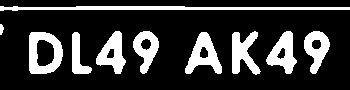

In [31]:
ret, thresh = cv2.threshold(bfilter, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
display(thresh, '2 - Binarization with OTSU thresholding method (For white plates)')

#Dilation:

Leggero ingrandimento dei caratteri utile quando quest'ultimi sono molto fini.

Re-invertimento dei colori.

3 - Dilation (for plates with thin characters)



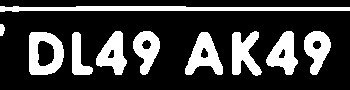

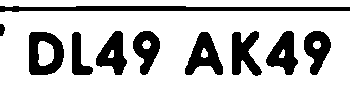

In [32]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
display(dilation, '3 - Dilation (for plates with thin characters)')
display(cv2.bitwise_not(dilation), '')

#Erosion:

Leggera diminuzione dello spessore dei caratteri utile quando quest'ultimi sono molto spessi.

3 - Erosion (for plates with thick characters)



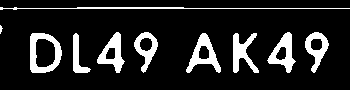

In [33]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
erosion = cv2.erode(thresh, rect_kern, iterations = 1)
display(erosion, '3 - Erosion (for plates with thick characters)')

#OBJECT CHARACTER RECOGNITION

#Confronto tra EasyOCR e Pytesseract:

In questa fase avviene il vero e proprio riconoscimento dei caratteri, attraverso due librierie python.
In base a vari test posso affermare che Pytesseract risulta migliore per scannerizzare lunghi testi ed è inoltre più leggero di EasyOCR in quanto utilizza esclusivamente la CPU.
Al contrario EasyOCR sembra essere migliore per l'estrazione dei caratteri di una targa in quanto "Esclude" meglio eventuali rumori nell'immagine richiedendo però una maggiore capacita computazionale.

In [34]:
res1 = reader.readtext(dilation)
res2 = reader.readtext(cv2.bitwise_not(dilation))
res3 = reader.readtext(cv2.bitwise_not(erosion))
res4 = reader.readtext(gray)
print()
t = ''
print('res1: ')
for i in range(len(res1)):
  print(res1[i])

print('res2: ')
for i in range(len(res2)):
  if i >= 3:
    break
  print(res2[i])
  t += res2[i][-2]

print('res3: ')
for i in range(len(res3)):
  print(res3[i])

print()
t2 = ''
for i in range(len(res4)):
  t2 += res4[0][-2]
final = ''
for c in t2:
  if c.isalnum():
    final += c
print('Easy-OCR on grayscale plate: ',final.upper().strip())
final = ''
for c in t:
  if c.isalnum():
    final += c
print('Easy-OCR after thresholding plate: ', final.upper().strip())
t = pytesseract.image_to_string(gray)
final = ''
for c in t:
  if c.isalnum():
    final += c
print('Pytesseract OCR on grayscale plate: ', final.upper().strip())
t = pytesseract.image_to_string(dilation)
final = ''
for c in t:
  if c.isalnum():
    final += c
print('Pytesseract OCR after thresholding plate: ', final.upper().strip())


res1: 
([[21, 23], [341, 23], [341, 87], [21, 87]], 'DL49 AK4Q', 0.47211637236646437)
res2: 
([[23, 23], [341, 23], [341, 87], [23, 87]], 'DL49 AK49', 0.5384348625798168)
res3: 
([[22, 22], [167, 22], [167, 87], [22, 87]], 'DL49', 0.960880696773529)
([[183, 23], [337, 23], [337, 83], [183, 83]], 'Ak49', 0.7649453282356262)

Easy-OCR on grayscale plate:  DL49AK49
Easy-OCR after thresholding plate:  DL49AK49
Pytesseract OCR on grayscale plate:  DL49AK49
Pytesseract OCR after thresholding plate:  DL49AK49


Come possiamo notare eseguendo vari test non c'è mai un metodo che calcolerà sempre i corretti valori dei caratteri, per questo motivo ho scelto di mostrare in ogni caso i 4 risultati

#ANPR su immagini scattate personalmente

In [35]:
command2 = 'python detect.py --weights ./checkpoints/custom-416 --size 416 --model yolov4 --images ./data/myImages/1.png --crop'

In [36]:
!{command2}

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening '/tmp/tmptadgshxn.PNG'


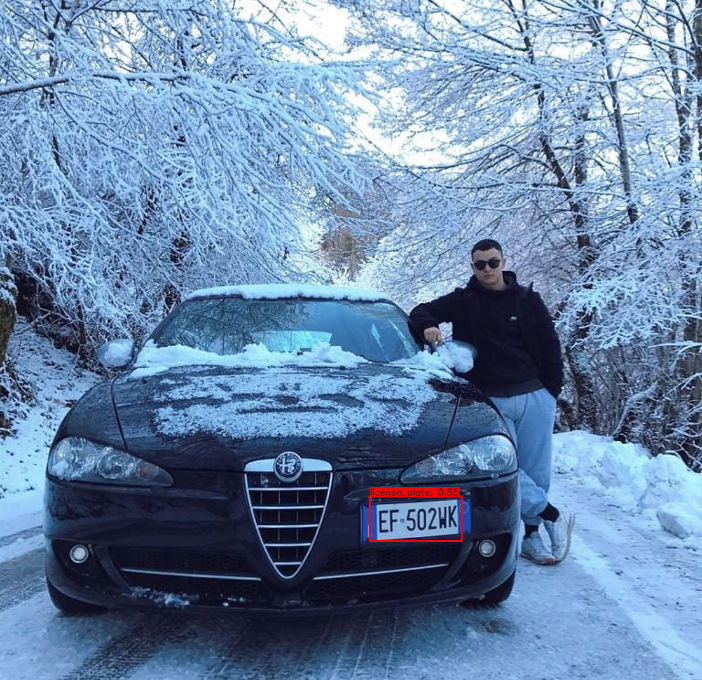

In [38]:
res = cv2.imread("/content/drive/MyDrive/tensorflow-yolov4-tflite-master/detections/detection1.png")
res = cv2.resize(res, None, fy=0.6, fx=0.6, interpolation=cv2.INTER_CUBIC)
cv2_imshow(res)

Dopo l'esecuzione della prossima cella tornare alla fase di preprocessing del notebook per effetuare OCR sulla targa appena ottenuta.

0 - Recognized plate with my YOLO v4 custom model:



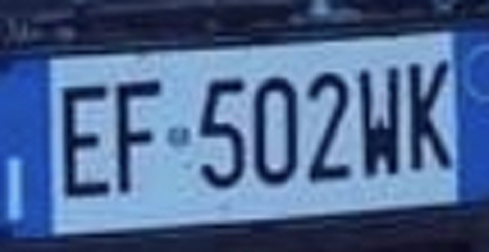

In [42]:
plate_PATH = '/content/drive/MyDrive/tensorflow-yolov4-tflite-master/detections/crop/1/license_plate_1.png'
p = cv2.imread(plate_PATH)
from scipy.ndimage import interpolation
plate = cv2.resize(p, None, fy=3, fx=3, interpolation=cv2.INTER_CUBIC)
display(plate, '0 - Recognized plate with my YOLO v4 custom model:')

#-Simone Pascucci 1895398

#Progetto finale "Laboratorio di intelligenza artificiale"